In [1]:
# Add submodule paths
import sys
sys.path += ['./normalizing_flows', './baselines', './climdex']

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import utils.data as data_util
import utils.nn_util as nn
import utils.plot as plot
import xarray as xr
import gcsfs
import dscnn
import climdex.temperature as tdex
import utils.metrics as metrics
from regions import southeast_us, pacific_nw
from datasource import EraiRasDataLoader
from utils.preprocessing import remove_monthly_means, restore_monthly_means
from utils.distributions import BernoulliLogNormal, normal, bernoulli_gamma
from utils.plot import plot_image_map
from tensorflow.keras.optimizers import Adamax
from tqdm import tqdm
from normalizing_flows.models import VariationalModel, FlowLVM, JointFlowLVM, adversarial
from normalizing_flows.models.variational import nll_loss
from normalizing_flows.models.optimization import LinearWarmupSchedule
from normalizing_flows.flows import Transform, Flow, Invert, Cbrt
from normalizing_flows.flows.image import Upsample
from normalizing_flows.flows.glow import GlowFlow, coupling_nn_glow
#tf.autograph.set_verbosity(1)
#tf.config.experimental_run_functions_eagerly(True)
#tf.debugging.set_log_device_placement(True)

In [3]:
data = EraiRasDataLoader(gcs_bucket='erai-rasmussen', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# era-interim
erai_deg1 = xr.open_zarr(data.erai('daily-1deg'), consolidated=True)
# 1-degree regridded rasmussen
ras_deg1 = xr.open_zarr(data.rasmussen('daily-1deg'), consolidated=True)
# 1/2-degree regridded rasmussen
ras_deg12 = xr.open_zarr(data.rasmussen('daily-1-2deg'), consolidated=True)
ras_deg14 = xr.open_zarr(data.rasmussen('daily-1-4deg'), consolidated=True)
ras_deg18 = xr.open_zarr(data.rasmussen('daily-1-8deg'), consolidated=True)
#ras_deg116 = xr.open_zarr(rasmussen('daily-1-16deg'), consolidated=True)
erai_deg1_seus = pacific_nw(erai_deg1)
ras_deg1_seus = pacific_nw(ras_deg1)
ras_deg12_seus = pacific_nw(ras_deg12, scale_factor=2)
ras_deg14_seus = pacific_nw(ras_deg14, scale_factor=4)
ras_deg18_seus = pacific_nw(ras_deg18, scale_factor=8)
# create train/test splits
split_fn = data_util.create_time_series_train_test_generator(n_splits=3)
def preprocess_prcp(ds):
    prcp = ds[['PRCP']].fillna(0.)
    prcp = np.cbrt(prcp)
    prcp = xr.where(prcp < 1.0, np.random.uniform(0.0, 1.0, size=(prcp.Time.size, prcp.lat.size, prcp.lon.size)), prcp)
    return prcp
ras_seus_prcp_12 = preprocess_prcp(ras_deg12_seus)
ras_seus_prcp_14 = preprocess_prcp(ras_deg14_seus)
ras_seus_prcp_18 = preprocess_prcp(ras_deg18_seus)
ras_seus_prcp_1 = preprocess_prcp(ras_deg1_seus)
erai_seus_prcp_1 = preprocess_prcp(erai_deg1_seus)
N = ras_deg1.Time.size
# create validation folds from all but last year of data
folds = list(split_fn(erai_seus_prcp_1.isel(Time=slice(0,N-2*365)), ras_seus_prcp_14.isel(Time=slice(0,N-2*365))))

In [4]:
def preprocess_vds(data_lo, data_hi, batch_size=100, buffer_size=1000, supervised=True):
    if supervised:
        data = tf.data.Dataset.zip((data_lo, data_hi)).shuffle(buffer_size)
    else:
        data = tf.data.Dataset.zip((data_lo.shuffle(buffer_size), data_hi.shuffle(buffer_size)))
    return data.batch(batch_size)

In [5]:
indices = tdex.indices('Time')
def eval_climdex(true, pred, coords):
    true_arr = xr.DataArray(true, coords=coords)
    pred_arr = xr.DataArray(pred, coords=coords)
    txx_true = indices.monthly_txx(true_arr)
    txx_pred = indices.monthly_txx(pred_arr)
    txn_true = indices.monthly_txn(true_arr)
    txn_pred = indices.monthly_txn(pred_arr)
    txx_bias = txx_pred - txx_true
    txn_bias = txn_pred - txn_true
    return txx_bias, txn_bias

### Glow: Latent variable estimation

The goal of variational inference is to estimate $q(z) \approx p(z|x) = \frac{p(x,z)}{\int p(x,z)dz}$

Normalizing flows attempt to learn an invertible function $f$ s.t. for $z_0$ drawn form initial variational density $q_0$, $z = f(z_0) \sim q(z)$, where $f$ is arbitrarily complex. This allows the model to learn better approximations of the posterior than otherwise possible with traditional, simple variational densities (such as a spherical Gaussian or standard logistic).

Glow (Kingma et al. 2018) is a state of the art normalizing flow designed for image data. It is an extension of RealNVP that generalizes the channel-wise permutation steps using an invertible 1x1 convolution.

In [6]:
def prcp_flow(layers, depth, min_filters=32, max_filters=256, name='flow'):
    glow = GlowFlow(num_layers=layers, depth=depth, coupling_nn_ctor=coupling_nn_glow(min_filters=min_filters, max_filters=max_filters), name=name)
    flow = Invert(glow) #Invert(Flow([Cbrt(), glow]))
    return flow

def upsample(new_wt, new_ht, method, scale_factor=1):
    @tf.function
    def _upsample(x):
        return tf.image.resize(x, (new_wt,new_ht), method=method) / scale_factor
    return _upsample

def spatial_mae(scale, stride=1):
    """
    "Spatial" MAE auxiliary loss for generator. Penalizes outputs
    which violate spatial average preservation between input and output.
    """
    kernel = tf.ones((scale,scale,1,1)) / (scale**2.)
    def _spatial_mse(x_in, y_pred):
        x_avg = tf.nn.conv2d(x_in, kernel, strides=(stride, stride), padding='VALID')
        y_avg = tf.nn.conv2d(y_pred, kernel, strides=(stride, stride), padding='VALID')
        return tf.math.reduce_mean(tf.math.abs(y_avg - x_avg))
    return _spatial_mse

def plot_1xn(data, title):
    n = len(data)
    plt.figure(figsize=(n*9,6))
    for i in range(n):
        plt.subplot(1,n,i+1)
        y = tf.where(data[i] > 1.0, data[i], 0.0)
        plt.imshow(y.numpy().squeeze(), origin='lower')
        plt.colorbar(pad=0.04, shrink=0.5)
    plt.suptitle(title, y=0.82)
    plt.show()

def fit_glow_jflvm(fold, n_epochs=50, validate_freq=1, warmup=1, sample_batch_size=10, load_batch_size=1200,
                   layers=4, depth=8, min_filters=32, max_filters=256, lam=1.0, alpha=0.0, critic_pre_train_steps=10):
    ((train_lo, train_hi), (test_lo, test_hi)) = fold
    N_train, N_test = train_lo.Time.size, test_lo.Time.size
    (wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
    scale = wt_hi // wt
    print('{} training samples, {} test samples, {}x{} -> {}x{}'.format(N_train, N_test, wt, ht, wt_hi, ht_hi))
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
#     train_lo, monthly_means_lo = remove_monthly_means(train_lo)
#     train_hi, monthly_means_hi = remove_monthly_means(train_hi)
#     test_lo,_ = remove_monthly_means(test_lo, monthly_means_lo)
#     test_hi,_ = remove_monthly_means(test_hi, monthly_means_hi)
#     train_scale_lo = train_lo.max()
#     train_scale_hi = train_hi.max()
#     train_lo = (train_lo / train_scale_lo)
#     train_hi = (train_hi / train_scale_hi)
#     test_lo = (test_lo / train_scale_lo)
#     test_hi = (test_hi / train_scale_hi)
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size).map(upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR))
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size).map(upsample(wt_hi, ht_hi, tf.image.ResizeMethod.NEAREST_NEIGHBOR))
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vds(train_lo_ds, train_hi_ds, batch_size=sample_batch_size, buffer_size=N_train, supervised=False)
    test_ds = preprocess_vds(test_lo_ds, test_hi_ds, batch_size=sample_batch_size, buffer_size=N_test, supervised=False)
    test_ds_paired = preprocess_vds(test_lo_ds, test_hi_ds, batch_size=1, buffer_size=N_test, supervised=True)
    flow_hr = prcp_flow(layers=layers, depth=depth, max_filters=256, name='flow_hr')
    flow_lr = prcp_flow(layers=layers, depth=depth, max_filters=256, name='flow_lr')
    #learning_rate = LinearWarmupSchedule(1.0E-3, num_warmup_steps=N_train//sample_batch_size*warmup_epochs)
    #p = (train_hi > 0).sum() / train_hi.count()
    #prior = BernoulliLogNormal(probs=p.values, mu=-0.5, sigma=1.0, epsilon=-0.4)
    prior = tfp.distributions.Logistic(loc=0., scale=1.)
    dx = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
    dy = adversarial.PatchDiscriminator((wt_hi,ht_hi,1))
#     model = FlowLVM(flow_hr, prior=prior, input_shape=(None,wt_hi,ht_hi,1))
#     model.train(train_ds.map(lambda x,y: y), steps_per_epoch=N_train//sample_batch_size, num_epochs=10)
#     samples = model.sample(n=4)
#     plot_1xn(samples, r"Samples $y \sim P(Y)$")
    model_joint = JointFlowLVM(flow_lr, flow_hr, dx, dy,
                               Gy_aux_loss=spatial_mae(scale),
                               input_shape=(None,wt_hi,ht_hi,1),
                               prior=prior)
    for i in range(0, n_epochs, validate_freq):
        print(f'Training joint model for {validate_freq} epochs ({i}/{n_epochs} complete)', flush=True)
        model_joint.train(train_ds, steps_per_epoch=N_train//sample_batch_size, num_epochs=validate_freq,
                          lam=lam, alpha=alpha)
        metrics = model_joint.evaluate(test_ds, N_test//sample_batch_size)
        # extract and log metrics
        mlflow.log_metrics({k: v[0] for k, v in metrics.items()})
        samples_x, samples_y = model_joint.sample(n=4)
        #samples_x = tf.clip_by_value(samples_x, 0.0, np.inf)
        #samples_y = tf.clip_by_value(samples_y, 0.0, np.inf)
        plot_1xn(samples_x, r"Samples $x \sim P(X)$")
        plot_1xn(samples_y, r"Samples $y \sim P(Y)$")
        x_t, y_t = next(test_ds_paired.__iter__())
        xp_t = model_joint.predict_x(y_t)
        yp_t = model_joint.predict_y(x_t)
        #xp_t = tf.clip_by_value(xp_t, 0.0, np.inf)
        #yp_t = tf.clip_by_value(yp_t, 0.0, np.inf)
        plot_1xn([x_t[0], y_t[0], xp_t[0], yp_t[0]], r"Predictions $X \leftrightarrow Y$")
    return model_joint

3100 training samples, 918 test samples, 8x16 -> 32x64


/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


Training joint model for 5 epochs (0/30 complete)


train:   0%|          | 0/1550 [00:00<?, ?it/s]/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):
eval: 100%|██████████| 91/91 [00:35<00:00,  2.59it/s, nll_x=2.06, nll_y=1.98, gx_loss=-2.97, gy_loss=10.4, dx_loss=-.31, dy_loss=443, gx_aux=0, gy_aux=1.83] 


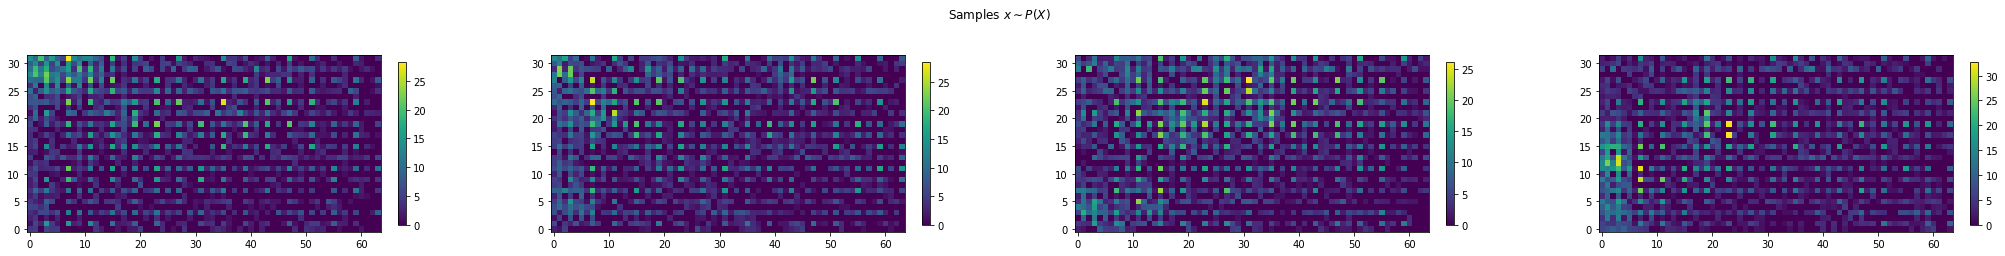

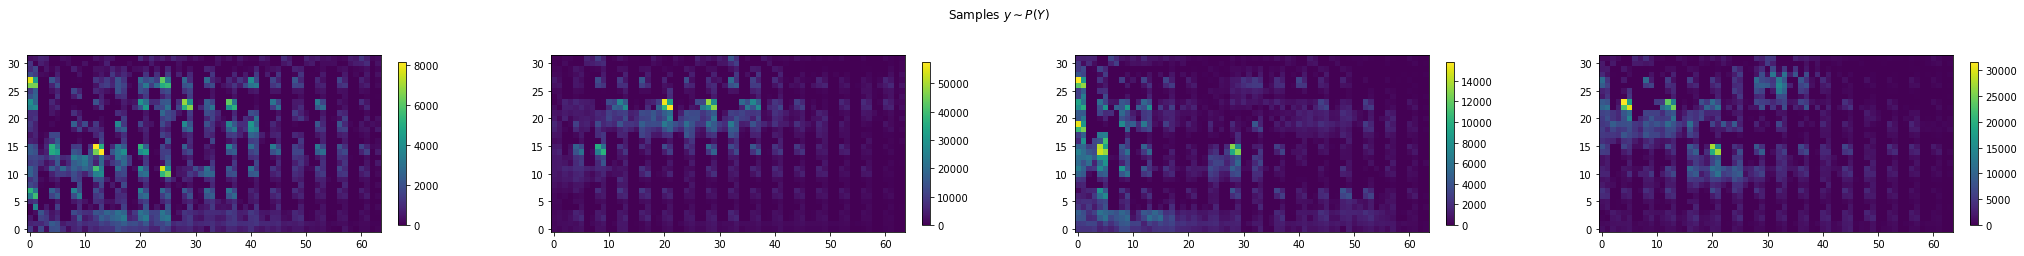

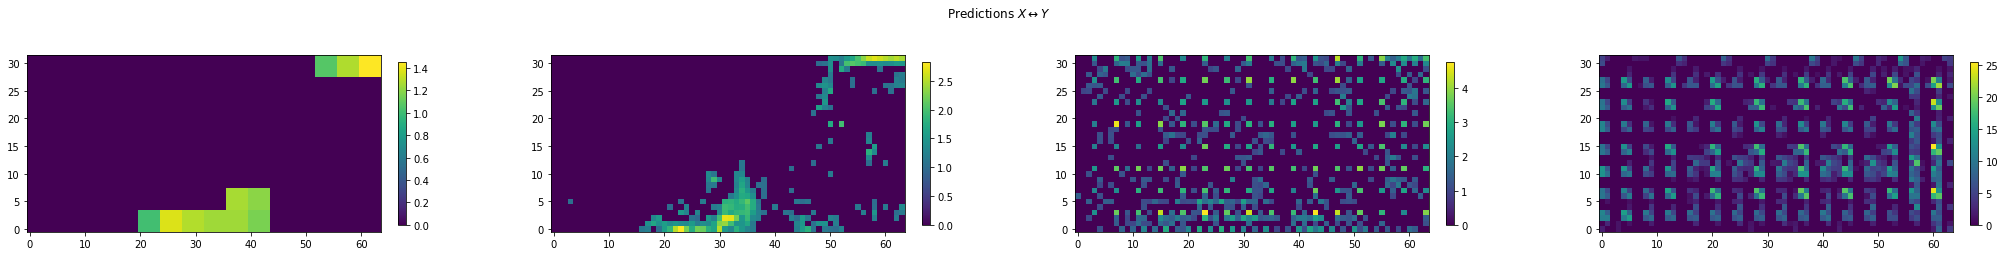

Training joint model for 5 epochs (5/30 complete)


eval: 100%|██████████| 91/91 [00:11<00:00,  7.85it/s, nll_x=-.467, nll_y=1.12, gx_loss=-1.66, gy_loss=10.2, dx_loss=0.00614, dy_loss=-.0454, gx_aux=0, gy_aux=0.25] 


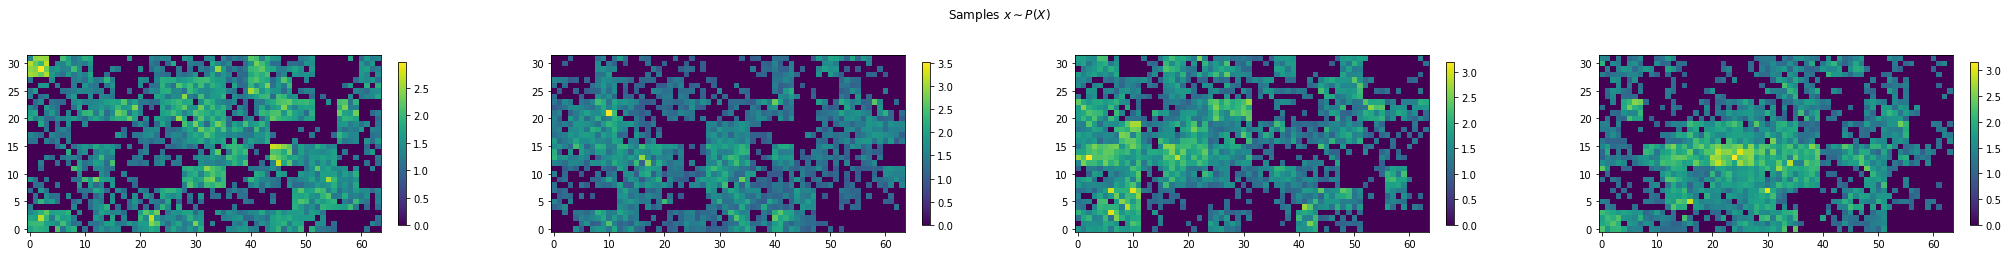

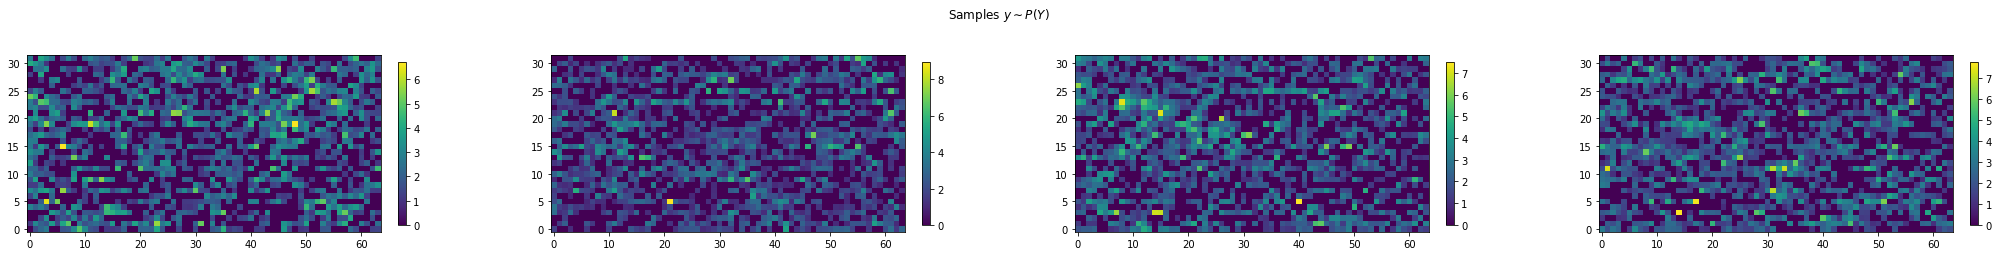

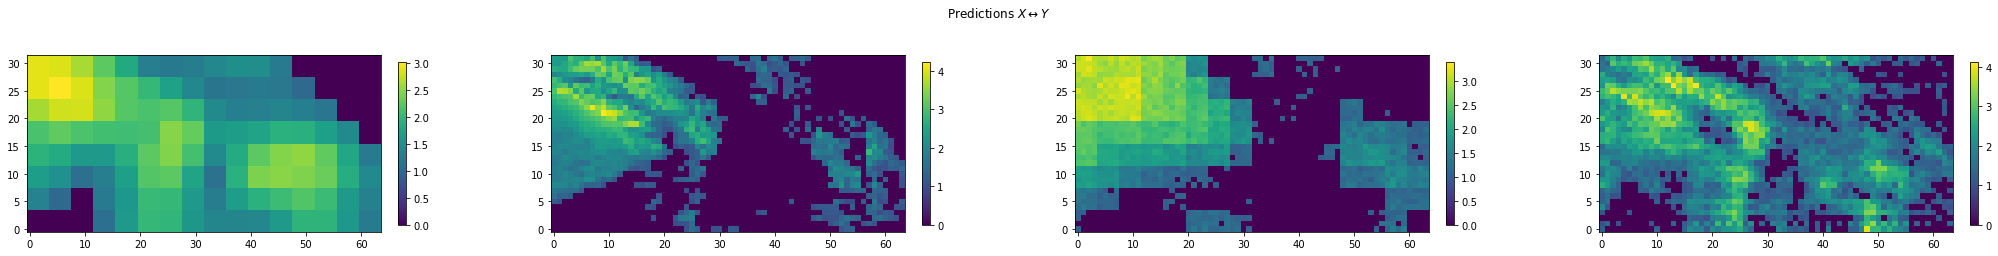

Training joint model for 5 epochs (10/30 complete)


eval: 100%|██████████| 91/91 [00:11<00:00,  7.74it/s, nll_x=-1.51, nll_y=0.778, gx_loss=-1.61, gy_loss=9.83, dx_loss=-.022, dy_loss=-.0565, gx_aux=0, gy_aux=0.352] 


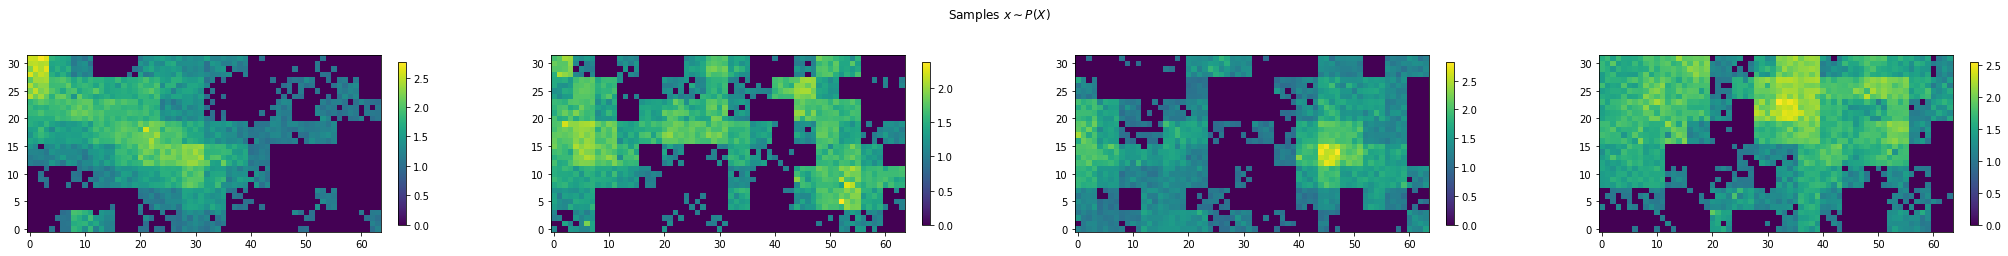

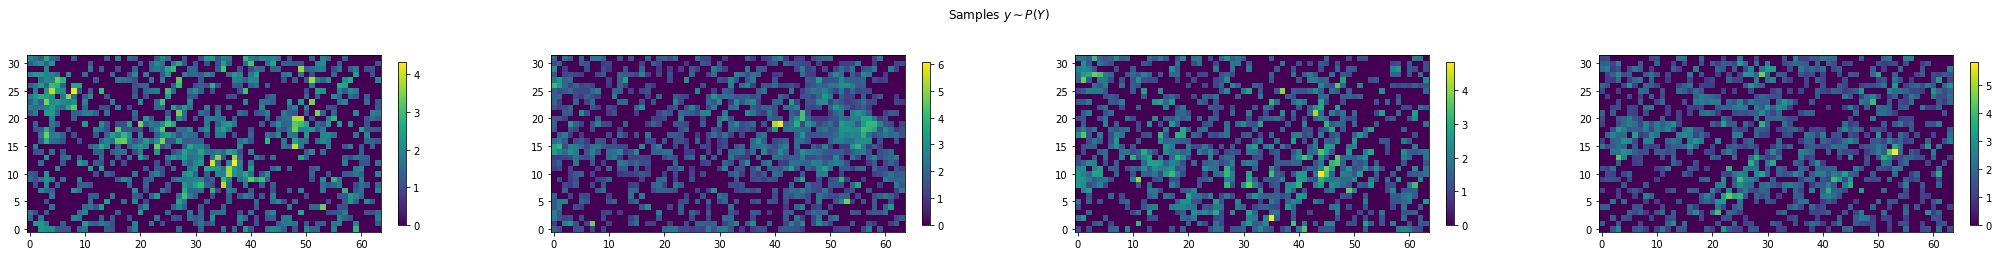

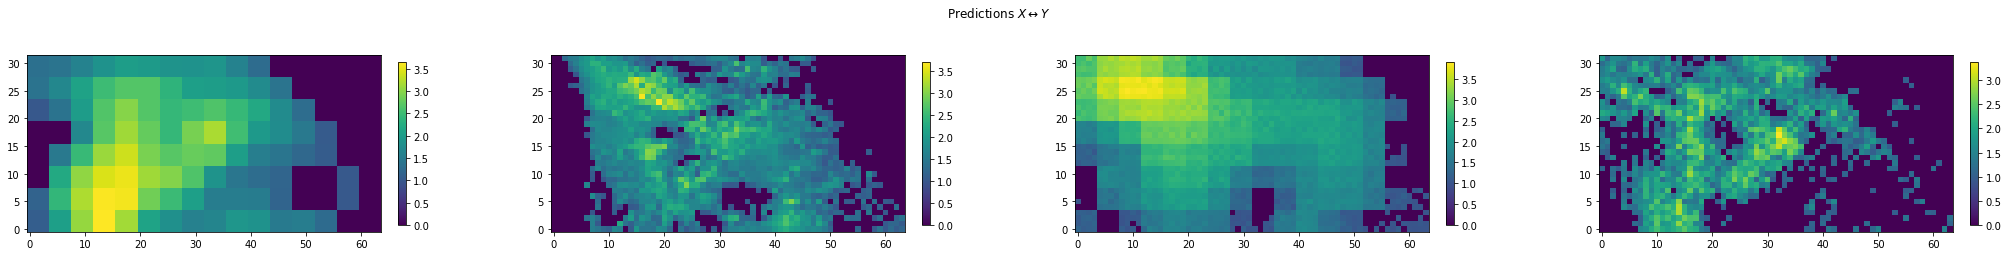

Training joint model for 5 epochs (15/30 complete)


train:   4%|▎         | 57/1550 [00:19<04:55,  5.06it/s, g_obj=8.23, gx_loss=-1.58, gy_loss=-.058, nll_x=-1.52, nll_y=0.754]  

In [ ]:
with mlflow.start_run() as run:
    model = fit_glow_jflvm(folds[-1], layers=3, depth=4, lam=0.1, n_epochs=30, validate_freq=5, critic_pre_train_steps=0)

In [ ]:
def fit_glow_inference_net(fold, n_epochs=50, validate_freq=1, warmup=1, sample_batch_size=10, load_batch_size=1200,
                           layers=4, depth=8, min_filters=32, max_filters=256, lam=1.0, alpha=1.0, critic_pre_train_steps=10):
    ((train_lo, train_hi), (test_lo, test_hi)) = fold
    N_train, N_test = train_lo.Time.size, test_lo.Time.size
    (wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
    scale = wt_hi // wt
    print('{} training samples, {} test samples, {}x{} -> {}x{}'.format(N_train, N_test, wt, ht, wt_hi, ht_hi))
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
#     train_lo, monthly_means_lo = remove_monthly_means(train_lo)
#     train_hi, monthly_means_hi = remove_monthly_means(train_hi)
#     test_lo,_ = remove_monthly_means(test_lo, monthly_means_lo)
#     test_hi,_ = remove_monthly_means(test_hi, monthly_means_hi)
#     train_scale_lo = train_lo.max()
#     train_scale_hi = train_hi.max()
#     train_lo = (train_lo / train_scale_lo) - 0.5
#     train_hi = (train_hi / train_scale_hi) - 0.5
#     test_lo = (test_lo / train_scale_lo) - 0.5
#     test_hi = (test_hi / train_scale_hi) - 0.5
    train_lo = xr.where(train_lo > 1.0, train_lo, 0.0)
    train_hi = xr.where(train_hi > 1.0, train_hi, 0.0)
    test_lo = xr.where(test_lo > 1.0, test_lo, 0.0)
    test_hi = xr.where(test_hi > 1.0, test_hi, 0.0)
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size)
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vds(train_lo_ds, train_hi_ds, batch_size=sample_batch_size, buffer_size=N_train, supervised=True)
    test_ds = preprocess_vds(test_lo_ds, test_hi_ds, batch_size=sample_batch_size, buffer_size=N_test, supervised=True)
    test_ds_paired = preprocess_vds(test_lo_ds, test_hi_ds, batch_size=1, buffer_size=N_test, supervised=True)
    flow_hr = Invert(GlowFlow(num_layers=layers, depth=depth, coupling_nn_ctor=coupling_nn_glow(max_filters=256)))
    encoder = dscnn.create_bmd_cnn10(wt, ht, scale=scale, c_out=2)
    model = VariationalModel(encoder, bernoulli_gamma(epsilon=1.0), optimizer=tf.keras.optimizers.Adam(lr=1.0E-4),
                             output_shape=(None, wt_hi, ht_hi, 1))
    model.fit(train_ds.repeat(n_epochs), epochs=n_epochs, steps_per_epoch=train_steps,
              validation_data=test_ds.repeat(n_epochs), validation_steps=test_steps)
    test_x, test_y = next(test_ds.__iter__())
    mean = model.mean(test_x)
    sample = model.sample(test_x)
    plt.figure(figsize=(4*9,6))
    plt.subplot(1,4,1)
    plt.imshow(test_x.numpy()[0].squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,2)
    plt.imshow(test_y.numpy()[0].squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,3)
    plt.imshow(mean[0].numpy().squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,4)
    plt.imshow(sample[0].numpy().squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.show()
    return model

In [ ]:
with mlflow.start_run() as run:
    model = fit_glow_inference_net(folds[-1], layers=4, depth=8, n_epochs=10, validate_freq=2, critic_pre_train_steps=0)